In [ ]:
import numpy as np
from scipy.stats import binom
from scipy.stats import poisson
from scipy import signal


def pa(params, model):
    cnt_diff_a = params['amax'] - params['amin'] + 1
    probs = np.full((cnt_diff_a), 1 / cnt_diff_a)
    vals = np.arange(params['amin'], params['amax'] + 1)
    return probs, vals


def pb(params, model):
    cnt_diff_b = params['bmax'] - params['bmin'] + 1
    probs = np.full((cnt_diff_b), 1 / cnt_diff_b)
    vals = np.arange(params['bmin'], params['bmax'] + 1)
    return probs, vals


def pc_ab_matrix(params, model):
    c_max = params['amax'] + params['bmax']
    vals = np.arange(c_max + 1)

    if model == 1:
        probs_bin_a = binom.pmf(
            vals[:params['amax'] + 1, np.newaxis],
            np.arange(params['amin'], params['amax'] + 1),
            params['p1']
            )
        probs_bin_b = binom.pmf(
            vals[:params['bmax'] + 1, np.newaxis],
            np.arange(params['bmin'], params['bmax'] + 1),
            params['p2']
            )

        probs = np.zeros((c_max + 1, params['amax'] - params['amin'] + 1, params['bmax'] - params['bmin'] + 1))
        for i in range(params['amax'] - params['amin'] + 1):
            for j in range(params['bmax'] - params['bmin'] + 1):
                probs[:, i, j] = np.convolve(probs_bin_a[:,i], probs_bin_b[:, j])
    elif model == 2:
        a_vals_mul_p1 = params['p1'] * np.arange(params['amin'], params['amax'] + 1)
        b_vals_mul_p2 = params['p2'] * np.arange(params['bmin'], params['bmax'] + 1)
        sum_ab_vals = b_vals_mul_p2[np.newaxis, :] + a_vals_mul_p1[:, np.newaxis]
        probs = poisson.pmf(
            vals[:, np.newaxis, np.newaxis],
            sum_ab_vals[np.newaxis, :,:]
            )
    return probs, vals


def pc(params, model):
    c_max = params['amax'] + params['bmax']
    vals = np.arange(c_max + 1)
    prob_a = 1 / (params['amax'] - params['amin'] + 1)
    prob_b = 1 / (params['bmax'] - params['bmin'] + 1)

    probs = pc_ab_matrix(params, model)[0].sum(axis=-1).sum(axis=-1)
    return probs * prob_a * prob_b, vals


def pd_c_matrix(params, model):
    vals = np.arange((params['amax'] + params['bmax']) * 2 + 1)
    probs_c, vals_c = pc(params, model)
    probs = binom.pmf(
            vals - vals_c[:, np.newaxis],
            vals_c[:, np.newaxis],
            params['p3']
    )

    return probs.T, vals


def pd(params, model):
    vals = np.arange((params['amax'] + params['bmax']) * 2 + 1)
    prob_c, _ = pc(params, model)
    probs_d_c, _ = pd_c_matrix(params, model)
    probs = probs_d_c * prob_c[np.newaxis, :]
    return probs.sum(axis=-1), vals


def pc_a(a, params, model):
    c_max = params['amax'] + params['bmax']
    vals = np.arange(c_max + 1)
    prob_b = 1 / (params['bmax'] - params['bmin'] + 1)

    Ind_a = a - params['amin']
    probs, _ = pc_ab_matrix(params, model)
    probs = probs.sum(axis=-1)
    probs = probs[:, Ind_a]
    return probs * prob_b, vals


def pc_b(b, params, model):
    c_max = params['amax'] + params['bmax']
    vals = np.arange(c_max + 1)
    prob_a = 1 / (params['amax'] - params['amin'] + 1)

    Ind_b = b - params['bmin']
    prob,_ = pc_ab_matrix(params, model)
    prob = prob[:, :, Ind_b]
    prob = prob.sum(axis=1)
    return prob * prob_a, vals


def pc_d(d, params, model):
    c_max = params['amax'] + params['bmax']
    vals = np.arange(c_max + 1)
    prob_dc,_ = pd_c_matrix(params, model)
    prob_c, _ = pc(params, model)

    prob_d = (prob_dc * prob_c[np.newaxis, :]).sum(axis=-1)

    Ind_d = d

    prob = prob_dc[Ind_d, :] * prob_c[np.newaxis, :]
    prob = prob / prob_d[Ind_d][:, np.newaxis]
    return prob.T, vals


def pc_ab(a, b, params, model):
    c_max = params['amax'] + params['bmax']
    vals = np.arange(c_max + 1)

    Ind_a = a - params['amin']
    Ind_b = b - params['bmin']
    probs = pc_ab_matrix(params, model)[0][:, Ind_a, :][:,:,Ind_b]
    return probs, vals

def pc_abd(a, b, d, params, model):
    c_max = params['amax'] + params['bmax']
    vals = np.arange(c_max + 1)

    Ind_a = a - params['amin']
    Ind_b = b - params['bmin']
    Ind_d = d

    prob_d_c = pd_c_matrix(params, model)[0][Ind_d, :]
    prob_c_ab = pc_ab_matrix(params, model)[0][:,:, Ind_b][:,Ind_a,:]
    prob_a = pa(params, model)[0][Ind_a]
    prob_b = pb(params, model)[0][Ind_b]

    probs_cabd = ((prob_c_ab * prob_b[np.newaxis, np.newaxis,:] * prob_a[np.newaxis,:, np.newaxis])[:,:,:, np.newaxis] * prob_d_c.T[:,np.newaxis, np.newaxis,:])
    probs_abd = probs_cabd.sum(axis=0)
    probs = probs_cabd / probs_abd[np.newaxis, :,:,:]

    return probs, vals

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
params = {'amin': 75, 'amax': 90, 'bmin': 500, 'bmax': 600,
              'p1': 0.1, 'p2': 0.01, 'p3': 0.3} 

a=np.arange(80,82)
b=np.arange(500,503)
d=np.arange(400,404)

In [ ]:
def expected_value(p, *args):
    probs, vals = p(*args)
    if len(args) == 3:
        probs = probs[:, 0]
    elif len(args) == 4:
        probs = probs[:, 0, 0]
    elif len(args) == 5:
        probs = probs[:, 0, 0, 0]
    return (probs * vals).sum()

In [ ]:
def variance(p, *args):
    probs, vals = p(*args)
    if len(args) == 3:
        probs = probs[:, 0]
    elif len(args) == 4:
        probs = probs[:, 0, 0]
    elif len(args) == 5:
        probs = probs[:, 0, 0, 0]
    e_2 = (probs * np.power(vals, 2)).sum()
    expected = expected_value(p, *args)
    return e_2 - (expected**2)


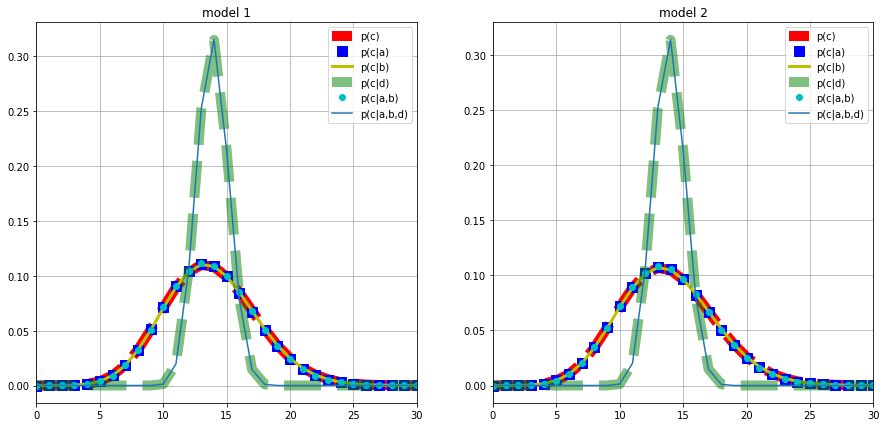

In [ ]:

plt.figure(figsize=(15, 7))

model = 1
plt.subplot(1, 2, 1)
plt.grid(True)
plt.title('model 1')


probs_c, vals_c = pc(params, model)
plt.plot(vals_c, probs_c, 'r--', linewidth=10, label='p(c)')

a = np.array([round(expected_value(pa, params, model))])
probs_c_a, vals_c_a = pc_a(a, params, model)
plt.plot(vals_c_a, probs_c_a, 'bs', markersize=10, label='p(c|a)')

b = np.array([round(expected_value(pb, params, model))])
probs_c_b, vals_c_b = pc_b(b, params, model)
plt.plot(vals_c_b, probs_c_b, c='y', linewidth=3, label='p(c|b)')


d = np.array([round(expected_value(pd, params, model))])
probs_c_d, vals_c_d = pc_d(d, params, model)
plt.plot(vals_c_d, probs_c_d, 'g--', linewidth=10, alpha =0.5, label='p(c|d)')

probs_c_ab, vals_c_ab = pc_ab(a, b, params, model)
plt.plot(vals_c_ab, probs_c_ab[:, 0, 0],'co', label='p(c|a,b)')


probs_c_abd, vals_c_abd = pc_abd(a, b, d, params, model)
plt.plot(vals_c_abd, probs_c_abd[:, 0, 0, 0], label='p(c|a,b,d)')

plt.legend()
plt.xlim(0, 30)

model = 2
plt.subplot(1, 2, 2)
plt.grid(True)
plt.title('model 2')

probs_c, vals_c = pc(params, model)
plt.plot(vals_c, probs_c, 'r--', linewidth=10, label='p(c)')

a = np.array([round(expected_value(pa, params, model))])
probs_c_a, vals_c_a = pc_a(a, params, model)
plt.plot(vals_c_a, probs_c_a, 'bs', markersize=10, label='p(c|a)')

b = np.array([round(expected_value(pb, params, model))])
probs_c_b, vals_c_b = pc_b(b, params, model)
plt.plot(vals_c_b, probs_c_b, c='y', linewidth=3, label='p(c|b)')


d = np.array([round(expected_value(pd, params, model))])
probs_c_d, vals_c_d = pc_d(d, params, model)
plt.plot(vals_c_d, probs_c_d,'g--', linewidth=10, alpha =0.5, label='p(c|d)')

probs_c_ab, vals_c_ab = pc_ab(a, b, params, model)
plt.plot(vals_c_ab, probs_c_ab[:, 0, 0], 'co', label='p(c|a,b)')

probs_c_abd, vals_c_abd = pc_abd(a, b, d, params, model)
plt.plot(vals_c_abd, probs_c_abd[:, 0, 0, 0], label='p(c|a,b,d)')

plt.legend()
plt.xlim(0, 30)

plt.savefig("distrib.pdf", bbox_inches='tight')
plt.show()


In [ ]:
model = 1
print('Model 1')
print('Expected value p(c) : ', round(expected_value(pc, params, model), 2))
print('Variance value p(c) : ', round(variance(pc, params, model), 2), '\n')


a = np.array([round(expected_value(pa, params, model))])
print('Expected value p(c|a) : ', round(expected_value(pc_a, a, params, model), 2))
print('Variance value p(c|a) : ', round(variance(pc_a, a, params, model), 2), '\n')

b = np.array([round(expected_value(pb, params, model))])
print('Expected value p(c|b) : ', round(expected_value(pc_b, b, params, model), 2))
print('Variance value p(c|b) : ', round(variance(pc_b, b, params, model), 2), '\n')

d = np.array([round(expected_value(pd, params, model))])
print('Expected value p(c|d) : ', round(expected_value(pc_d, d, params, model), 2))
print('Variance value p(c|d) : ', round(variance(pc_d, d, params, model), 2), '\n')


print('Expected value p(c|a,b) : ', round(expected_value(pc_ab, a, b, params, model), 2))
print('Variance value p(c|a,b) : ', round(variance(pc_ab, a, b, params, model), 2), '\n')

print('Expected value p(c|a,b,d) : ', round(expected_value(pc_abd, a, b, d, params, model), 2))
print('Variance value p(c|a,b,d) : ', round(variance(pc_abd, a, b, d, params, model), 2), '\n')


model = 2
print('Model 2')
print('Expected value p(c) : ', round(expected_value(pc, params, model), 2))
print('Variance value p(c) : ', round(variance(pc, params, model), 2), '\n')

a = np.array([round(expected_value(pa, params, model))])
print('Expected value p(c|a) : ', round(expected_value(pc_a, a, params, model), 2))
print('Variance value p(c|a) : ', round(variance(pc_a, a, params, model), 2), '\n')

b = np.array([round(expected_value(pb, params, model))])
print('Expected value p(c|b) : ', round(expected_value(pc_b, b, params, model), 2))
print('Variance value p(c|b) : ', round(variance(pc_b, b, params, model), 2), '\n')

d = np.array([round(expected_value(pd, params, model))])
print('Expected value p(c|d) : ', round(expected_value(pc_d, d, params, model), 2))
print('Variance value p(c|d) : ', round(variance(pc_d, d, params, model), 2), '\n')


print('Expected value p(c|a,b) : ', round(expected_value(pc_ab, a, b, params, model), 2))
print('Variance value p(c|a,b) : ', round(variance(pc_ab, a, b, params, model), 2), '\n')

print('Expected value p(c|a,b,d) : ', round(expected_value(pc_abd, a, b, d, params, model), 2))
print('Variance value p(c|a,b,d) : ', round(variance(pc_abd, a, b, d, params, model), 2), '\n')

Model 1
Expected value p(c) :  13.75
Variance value p(c) :  13.17 

Expected value p(c|a) :  13.7
Variance value p(c|a) :  12.91 

Expected value p(c|b) :  13.75
Variance value p(c|b) :  13.08 

Expected value p(c|d) :  13.9
Variance value p(c|d) :  1.53 

Expected value p(c|a,b) :  13.7
Variance value p(c|a,b) :  12.83 

Expected value p(c|a,b,d) :  13.89
Variance value p(c|a,b,d) :  1.53 

Model 2
Expected value p(c) :  13.75
Variance value p(c) :  14.05 

Expected value p(c|a) :  13.7
Variance value p(c|a) :  13.79 

Expected value p(c|b) :  13.75
Variance value p(c|b) :  13.96 

Expected value p(c|d) :  13.89
Variance value p(c|d) :  1.54 

Expected value p(c|a,b) :  13.7
Variance value p(c|a,b) :  13.7 

Expected value p(c|a,b,d) :  13.89
Variance value p(c|a,b,d) :  1.54 



In [ ]:
model = 1
probs, vals_d = pd(params, model)
var_c_d = np.array([variance(pc_d, np.array([i]), params, model) for i in vals_d]) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
probs, vals_b = pb(params, model)
var_c_b = np.array([variance(pc_b, np.array([i]), params, model) for i in vals_b] )

In [ ]:
(var_c_d[:, np.newaxis] > var_c_b[np.newaxis, :]).sum()

0

In [ ]:
probs, vals_a = pa(params, model)
var_c_a = np.array([variance(pc_a, np.array([i]), params, model) for i in vals_a]) 

In [ ]:
(var_c_d[:, np.newaxis] > var_c_a[np.newaxis, :]).sum()

0

In [ ]:
x, y = np.where(var_c_b[:, np.newaxis] < var_c_a[np.newaxis, :])

In [ ]:
q, w = np.where(var_c_b[:, np.newaxis] > var_c_a[np.newaxis, :])

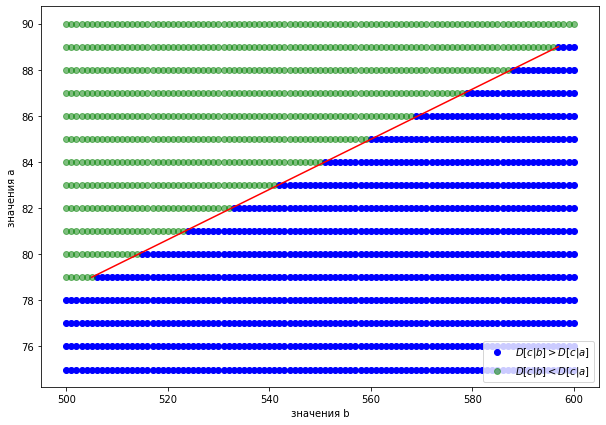

In [ ]:
plt.figure(figsize=(10, 7))
plt.scatter(vals_b[q], vals_a[w], c='b', label='$D[c|b] > D[c|a]$' )
plt.scatter(vals_b[x], vals_a[y], c='g', alpha=0.5, label='$D[c|b] < D[c|a]$')
plt.plot([505, 597], [79, 89], c = 'r')

plt.xlabel('значения b')
plt.ylabel('значения a')
plt.legend(loc='lower right')
plt.savefig('lin.pdf',  bbox_inches='tight')
plt.show()

In [ ]:
model = 2
probs, vals_d_2 = pd(params, model)
var_c_d_2 = np.array([variance(pc_d, np.array([i]), params, model) for i in vals_d_2]) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
probs, vals_b_2 = pb(params, model)
var_c_b_2 = np.array([variance(pc_b, np.array([i]), params, model) for i in vals_b_2] )

In [ ]:
(var_c_d_2[:, np.newaxis] > var_c_b_2[np.newaxis, :]).sum()

14955

In [ ]:
probs, vals_a_2 = pa(params, model)
var_c_a_2 = np.array([variance(pc_a, np.array([i]), params, model) for i in vals_a_2]) 

In [ ]:
(var_c_d_2[:, np.newaxis] > var_c_a_2[np.newaxis, :]).sum()

2457

In [ ]:
x2, y2 = np.where(var_c_b_2[:, np.newaxis] < var_c_a_2[np.newaxis, :])

In [ ]:
q2, w2 = np.where(var_c_b_2[:, np.newaxis] > var_c_a_2[np.newaxis, :])

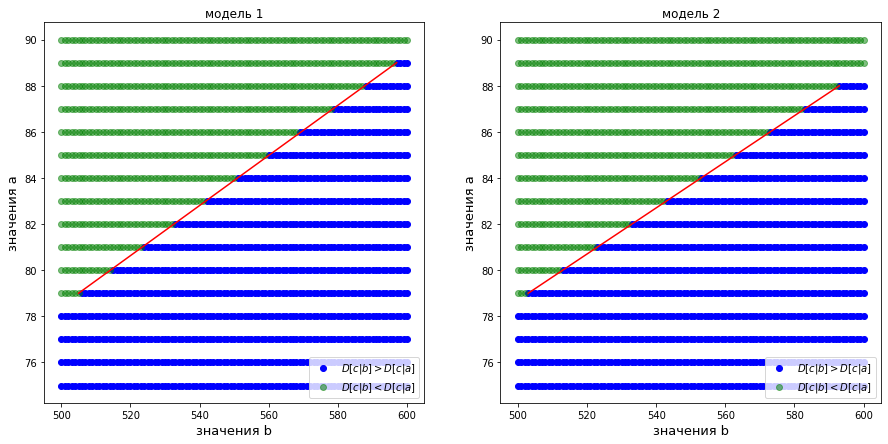

In [ ]:

plt.figure(figsize=(15, 7))

plt.subplot(1, 2, 1)
plt.title('модель 1')
plt.scatter(vals_b[q], vals_a[w], c='b', label='$D[c|b] > D[c|a]$' )
plt.scatter(vals_b[x], vals_a[y], c='g', alpha=0.5, label='$D[c|b] < D[c|a]$')
plt.plot([505, 597], [79, 89], c = 'r')

plt.xlabel('значения b', fontsize =13)
plt.ylabel('значения a', fontsize =13)
plt.legend(loc='lower right')


plt.subplot(1, 2, 2)
plt.title('модель 2')
plt.scatter(vals_b_2[q2], vals_a_2[w2], c='b', label='$D[c|b] > D[c|a]$' )
plt.scatter(vals_b_2[x2], vals_a_2[y2], c='g', alpha=0.5, label='$D[c|b] < D[c|a]$')
plt.plot([503, 593], [79, 88], c = 'r')

plt.xlabel('значения b', fontsize =13)
plt.ylabel('значения a', fontsize =13)
plt.legend(loc='lower right')
plt.savefig('lin.pdf',  bbox_inches='tight')
plt.show()

In [ ]:
import time

vals_a = np.arange(params['amin'], params['amax'] + 1)
vals_b = np.arange(params['bmin'], params['bmax'] + 1)
vals_d = np.arange((params['amax'] + params['bmax']) * 2 + 1)
model = 1

start_time = time.time()
expected_value(pc, params, model)
print('Time p(c) expected value computation', round(time.time() - start_time, 2) )

start_time = time.time()
variance(pc, params, model)
print('Time p(c) variance computation', round(time.time() - start_time, 2) )

start_time = time.time()
np.array([expected_value(pc_a, np.array([i]), params, model) for i in vals_a])
print('Time p(c|a) expected value computation', round(time.time() - start_time, 2) )

start_time = time.time()
np.array([variance(pc_a, np.array([i]), params, model) for i in vals_a])
print('Time p(c|a) variance computation', round(time.time() - start_time, 2) )

start_time = time.time()
np.array([expected_value(pc_b, np.array([i]), params, model) for i in vals_b])
print('Time p(c|b) expected value computation', round(time.time() - start_time, 2) )

start_time = time.time()
np.array([variance(pc_b, np.array([i]), params, model) for i in vals_b])
print('Time p(c|b) variance computation', round(time.time() - start_time, 2) )

start_time = time.time()
np.array([expected_value(pc_d, np.array([i]), params, model) for i in vals_d])
print('Time p(c|b) expected value computation', round(time.time() - start_time, 2) )

start_time = time.time()
np.array([variance(pc_d, np.array([i]), params, model) for i in vals_d])
print('Time p(c|d) variance computation', round(time.time() - start_time, 2) )



Time p(c) expected value computation 0.14
Time p(c) variance computation 0.28
Time p(c|a) expected value computation 2.21
Time p(c|a) variance computation 4.6
Time p(c|b) expected value computation 14.28
Time p(c|b) variance computation 34.17


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in true_divide


Time p(c|b) expected value computation 645.33
Time p(c|d) variance computation 1248.61


In [ ]:
start_time = time.time()
np.array([expected_value(pc_ab, np.array([i]), np.array([j]), params, model) for i, j in zip(vals_a, vals_b)])
print('Time p(c|a,b) expected value computation', round(time.time() - start_time, 2) )

start_time = time.time()
np.array([variance(pc_ab, np.array([i]), np.array([j]), params, model) for i, j in zip(vals_a, vals_b)])
print('Time p(c|a,b) variance computation', round(time.time() - start_time, 2) )

Time p(c|a,b) expected value computation 2.19
Time p(c|a,b) variance computation 4.44


In [ ]:
start_time = time.time()
np.array([expected_value(pc_abd, np.array([i]), np.array([j]), np.array([k]), params, model) for i, j, k in zip(vals_a, vals_b, vals_d)])
print('Time p(c|a,b,d) expected value computation', round(time.time() - start_time, 2) )

start_time = time.time()
np.array([variance(pc_abd, np.array([i]), np.array([j]), np.array([k]), params, model) for i, j, k in zip(vals_a, vals_b, vals_d)])
print('Time p(c|a,b,d) variance computation', round(time.time() - start_time, 2) )

Time p(c|a,b,d) expected value computation 7.57
Time p(c|a,b,d) variance computation 14.48


In [ ]:
vals_a = np.arange(params['amin'], params['amax'] + 1)
vals_b = np.arange(params['bmin'], params['bmax'] + 1)
vals_d = np.arange((params['amax'] + params['bmax']) * 2 + 1)
model = 2

start_time = time.time()
expected_value(pc, params, model)
print('Time p(c) expected value computation', round(time.time() - start_time, 2) )

start_time = time.time()
variance(pc, params, model)
print('Time p(c) variance computation', round(time.time() - start_time, 2) )

start_time = time.time()
np.array([expected_value(pc_a, np.array([i]), params, model) for i in vals_a])
print('Time p(c|a) expected value computation', round(time.time() - start_time, 2) )

start_time = time.time()
np.array([variance(pc_a, np.array([i]), params, model) for i in vals_a])
print('Time p(c|a) variance computation', round(time.time() - start_time, 2) )

start_time = time.time()
np.array([expected_value(pc_b, np.array([i]), params, model) for i in vals_b])
print('Time p(c|b) expected value computation', round(time.time() - start_time, 2) )

start_time = time.time()
np.array([variance(pc_b, np.array([i]), params, model) for i in vals_b])
print('Time p(c|b) variance computation', round(time.time() - start_time, 2) )

start_time = time.time()
np.array([expected_value(pc_d, np.array([i]), params, model) for i in vals_d])
print('Time p(c|b) expected value computation', round(time.time() - start_time, 2) )

start_time = time.time()
np.array([variance(pc_d, np.array([i]), params, model) for i in vals_d])
print('Time p(c|d) variance computation', round(time.time() - start_time, 2) )

Time p(c) expected value computation 0.33
Time p(c) variance computation 0.33
Time p(c|a) expected value computation 1.47
Time p(c|a) variance computation 2.48
Time p(c|b) expected value computation 6.77
Time p(c|b) variance computation 13.47


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in true_divide


Time p(c|b) expected value computation 435.15
Time p(c|d) variance computation 859.09


In [ ]:
start_time = time.time()
np.array([expected_value(pc_ab, np.array([i]), np.array([j]), params, model) for i, j in zip(vals_a, vals_b)])
print('Time p(c|a,b) expected value computation', round(time.time() - start_time, 2) )

start_time = time.time()
np.array([variance(pc_ab, np.array([i]), np.array([j]), params, model) for i, j in zip(vals_a, vals_b)])
print('Time p(c|a,b) variance computation', round(time.time() - start_time, 2) )

start_time = time.time()
np.array([expected_value(pc_abd, np.array([i]), np.array([j]), np.array([k]), params, model) for i, j, k in zip(vals_a, vals_b, vals_d)])
print('Time p(c|a,b,d) expected value computation', round(time.time() - start_time, 2) )

start_time = time.time()
np.array([variance(pc_abd, np.array([i]), np.array([j]), np.array([k]), params, model) for i, j, k in zip(vals_a, vals_b, vals_d)])
print('Time p(c|a,b,d) variance computation', round(time.time() - start_time, 2) )

Time p(c|a,b) expected value computation 1.1
Time p(c|a,b) variance computation 2.18
Time p(c|a,b,d) expected value computation 4.95
Time p(c|a,b,d) variance computation 9.91


In [ ]:
params = {'amin': 75, 'amax': 90, 'bmin': 500, 'bmax': 600,
              'p1': 0.9, 'p2': 0.9, 'p3': 0.3} 

a=np.arange(80,82)
b=np.arange(500,503)
d=np.arange(400,404)

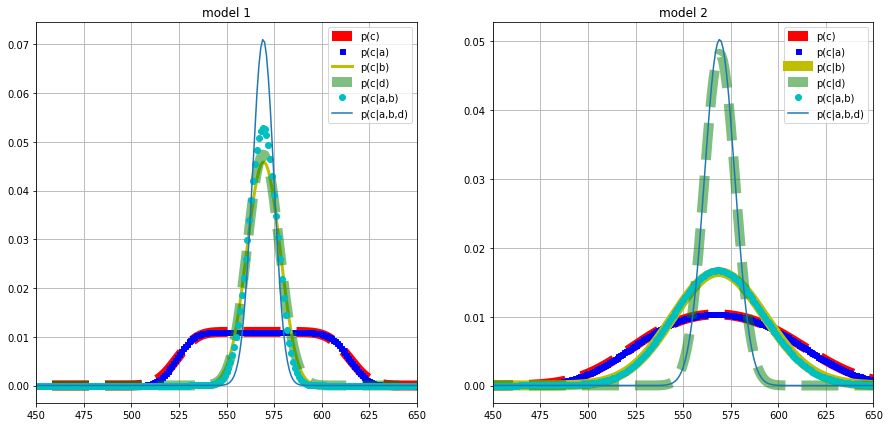

In [ ]:
plt.figure(figsize=(15, 7))

model = 1
plt.subplot(1, 2, 1)
plt.grid(True)
plt.title('model 1')


probs_c, vals_c = pc(params, model)
plt.plot(vals_c, probs_c, 'r--', linewidth=10, label='p(c)')

a = np.array([round(expected_value(pa, params, model))])
probs_c_a, vals_c_a = pc_a(a, params, model)
plt.plot(vals_c_a, probs_c_a, 'bs', markersize=5, label='p(c|a)')

b = np.array([round(expected_value(pb, params, model))])
probs_c_b, vals_c_b = pc_b(b, params, model)
plt.plot(vals_c_b, probs_c_b, c='y', linewidth=3, label='p(c|b)')


d = np.array([round(expected_value(pd, params, model))])
probs_c_d, vals_c_d = pc_d(d, params, model)
plt.plot(vals_c_d, probs_c_d, 'g--', linewidth=10, alpha =0.5, label='p(c|d)')

probs_c_ab, vals_c_ab = pc_ab(a, b, params, model)
plt.plot(vals_c_ab, probs_c_ab[:, 0, 0],'co', label='p(c|a,b)')


probs_c_abd, vals_c_abd = pc_abd(a, b, d, params, model)
plt.plot(vals_c_abd, probs_c_abd[:, 0, 0, 0], label='p(c|a,b,d)')

plt.legend()
plt.xlim(450, 650)

model = 2
plt.subplot(1, 2, 2)
plt.grid(True)
plt.title('model 2')

probs_c, vals_c = pc(params, model)
plt.plot(vals_c, probs_c, 'r--', linewidth=10, label='p(c)')

a = np.array([round(expected_value(pa, params, model))])
probs_c_a, vals_c_a = pc_a(a, params, model)
plt.plot(vals_c_a, probs_c_a, 'bs', markersize=5, label='p(c|a)')

b = np.array([round(expected_value(pb, params, model))])
probs_c_b, vals_c_b = pc_b(b, params, model)
plt.plot(vals_c_b, probs_c_b, c='y', linewidth=10, label='p(c|b)')


d = np.array([round(expected_value(pd, params, model))])
probs_c_d, vals_c_d = pc_d(d, params, model)
plt.plot(vals_c_d, probs_c_d,'g--', linewidth=10, alpha =0.5, label='p(c|d)')

probs_c_ab, vals_c_ab = pc_ab(a, b, params, model)
plt.plot(vals_c_ab, probs_c_ab[:, 0, 0], 'co', linewidth=0.5, label='p(c|a,b)')

probs_c_abd, vals_c_abd = pc_abd(a, b, d, params, model)
plt.plot(vals_c_abd, probs_c_abd[:, 0, 0, 0], label='p(c|a,b,d)')

plt.legend()
plt.xlim(450, 650)

plt.savefig("distrib.pdf", bbox_inches='tight')
plt.show()